## Libraries

In [0]:
!pip install es_lemmatizer
!python -m spacy download es_core_news_sm

In [0]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from es_lemmatizer import lemmatize

import spacy

nlp = spacy.load("/usr/local/lib/python3.6/dist-packages/es_core_news_sm/es_core_news_sm-2.2.5")
nlp.add_pipe(lemmatize, after="tagger")

## Files upload

In [0]:
f = open("/content/book.txt", "r") 
f = [line for line in f.readlines() if line.strip()]

## Lemmatize words to dictionary of frequency

In [128]:
org_num_words = 0
for line in f:
  org_num_words += len(line.split())
print('Number of words in the text: ', org_num_words)

words_lemma = {}
for i in range(len(f)):
  for token in nlp(re.sub('[:,\d\n?¿!¡()-.«»:;+©]|[\\x97]|[\\x92]', '', f[i])):
    if token.lemma_ in words_lemma.keys():
      words_lemma[token.lemma_] += 1 
    else:
      words_lemma[token.lemma_] = 1

Number of words in the text:  110042


Number of unique lemms in the text:  7412


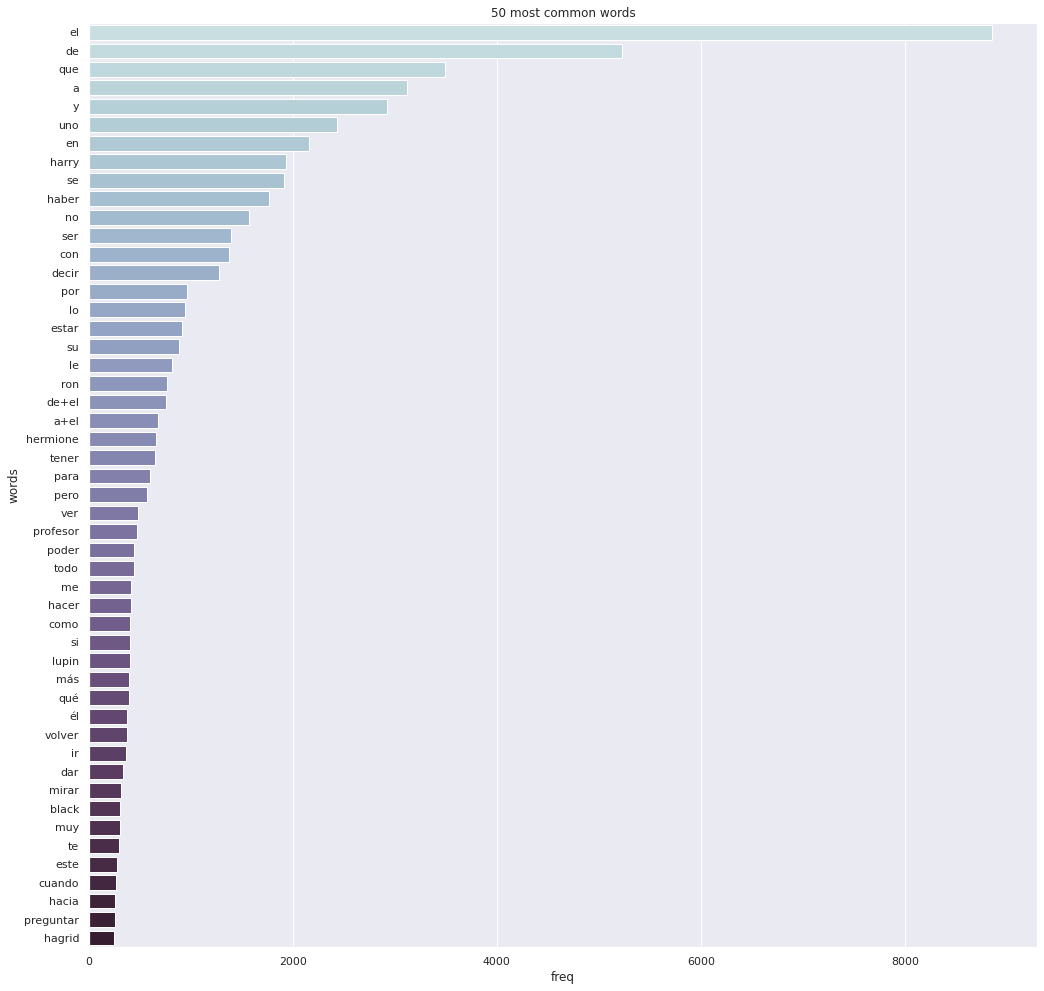

In [127]:
words_lemma_df = pd.DataFrame({'words':list(words_lemma.keys()), 'freq': list(words_lemma.values())}).sort_values(by=['freq'], ascending = False)
print('Number of unique lemms in the text: ', len(words_lemma))

sns.set(rc={'figure.figsize':(17,17)})
sns.barplot(x='freq',y='words',data=words_lemma_df.head(50), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('50 most common words');

# Distribution of the frequencies

In [0]:
i = 0
zipf_plot = []
for row in words_lemma_df.iterrows():
  zipf_plot += [[i, row[1].freq]]
  i+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """Entry point for launching an IPython kernel.


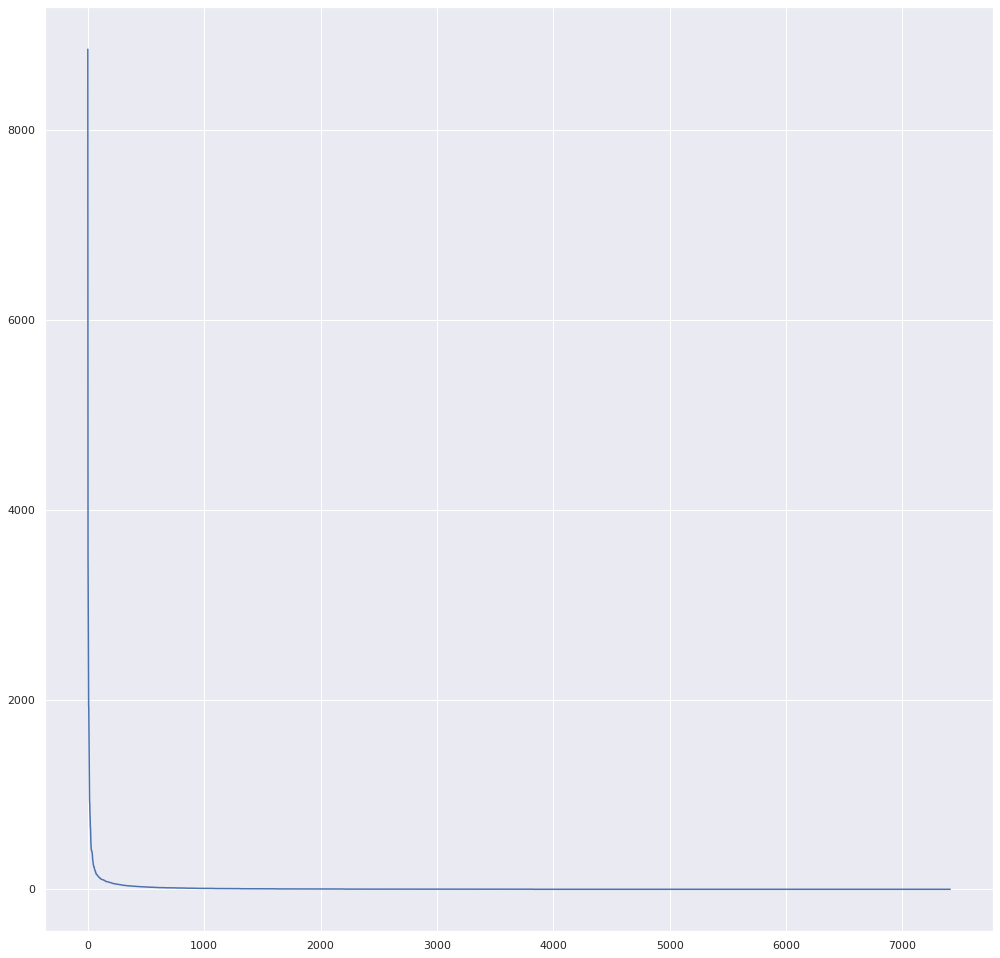

In [124]:
plt.plot('x', 'y', data=pd.DataFrame({'x':[x[0] for x in zipf_plot], 'y': [x[1] for x in zipf_plot]}))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """Entry point for launching an IPython kernel.


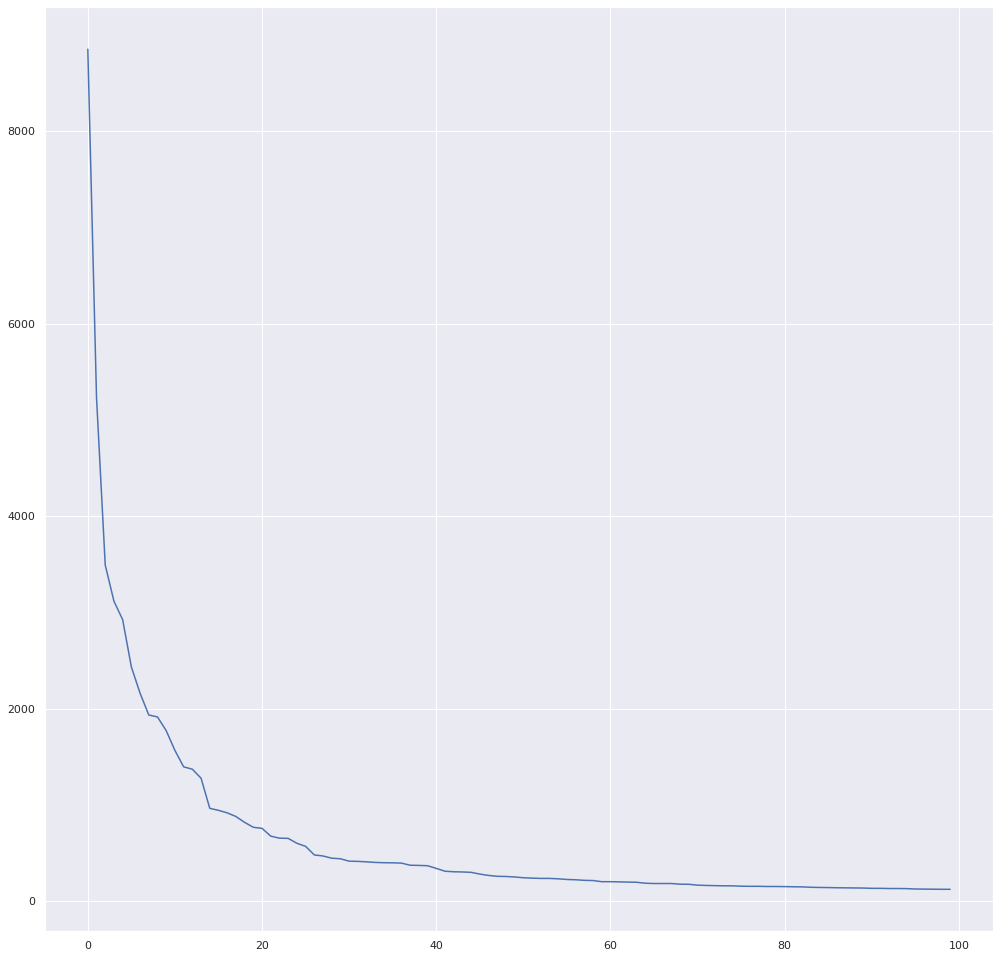

In [204]:
plt.plot('x', 'y', data=pd.DataFrame({'x':[x[0] for x in zipf_plot[:100]], 'y': [x[1] for x in zipf_plot[:100]]}))
plt.show()

And if we zoom in to the first 100 words (above) we are going to observe almost perfect curve predicted by the Zipf's law (below).

![zipf curve](https://scx1.b-cdn.net/csz/news/800/2017/solutiontoac.png)

In [0]:
words_lemma_df.to_csv('/content/data_or.csv')

# Language level of the text

In [0]:
levels = [(500, 'A1'),(1000, 'A2'),(2000, 'B1'),(4000, 'B2'),(8000,'C1'),(16000, 'C2'), ('more', 'fluent')]

In [0]:
def print_levels():
  print('\tThe table of levels (number of words learner should know)\n')
  for i in range(len(levels)-1):
    print('{} {} - {}'.format(levels[i][1],levels[i][0],levels[i+1][0]))
  print()

In [0]:
def get_level(number_unique_lemma, levels, pr = True):
  for i in range(len(levels)-1):
    if levels[i][0] > number_unique_lemma:
      levels_of_book = (levels[i-1], levels[i])
      break
    else:
      levels_of_book = levels[-2:]
  if(pr):
    print('Number of unique words {} correspond to (approximately) level {} (betwen {} and {} words).'.format(number_unique_lemma, levels_of_book[0][1],
                                                                                                         levels_of_book[0][0],levels_of_book[1][0]))
  return(levels_of_book)

In [156]:
print_levels()
number_unique_lemma = len(words_lemma)
levels_of_book_initial = get_level(number_unique_lemma, levels)

	The table of levels (number of words learner should know)

A1 500 - 1000
A2 1000 - 2000
B1 2000 - 4000
B2 4000 - 8000
C1 8000 - 16000
C2 16000 - more

Number of unique words 7412 correspond to (approximately) level B2 (betwen 4000 and 8000 words).


Really? Almost C1 to understand the Harry Potter? This doesn't seem corect. Children all over the world are reading it without having a degree (C1-C2 are considered to be college-level language). So let's dig deeper!

## How much is too much? (percent of the understanding)

Do you usually understand 100% of what you are reading? Even in your mother tongue? Yeah, you can guess some words and something just understand from the context. So what's a threshold? Let's for the sake of the experiment we say that we need to understand 90%, 93% or 95% of the text to say we **understand** it. Will the level of the book change a lot? (spoiler: it will ;) )

In [0]:
num_words_lemms = 0
for _, row in words_lemma_df.iterrows():
  num_words_lemms += row['freq']

In [0]:
def custom_range(max_val):
  result = [25, 50, 100] + [i*200 for i in range(1,5)]+ [i*1000 for i in range(1, max_val//1000+1)]
  if max_val%1000 == 0:
    return result
  else:
    return result + [max_val]

In [0]:
def count_percents(words_df, num_words, max_num = None):
  info = []
  if not max_num:
    max_num = words_df.shape[0]
  custom_ranges = custom_range(max_num)
  for index in range(0,max_num,25) or index == max_num:
    sums = 0
    for _, row in words_df.head(index).iterrows():
      sums += row['freq']
    if index in custom_ranges:
      print('{} most frequent words is {:2.2f}% of the text'.format(index, sums/num_words*100))
    info.append([index, sums/num_words*100])
  return info

In [171]:
for percent in [90,93,95]:
  for line in counts:
    if line[1]>percent:
      print('Knowing {} words you will understand {}% of the text'.format(line[0], line[1]))
      get_level(line[0], levels)
      number_unique_lemma_short = line[0]
      print()      
      break

Knowing 1450 words you will understand 90.04453330909752% of the text
Number of unique words 1450 correspond to (approximately) level A2 (betwen 1000 and 2000 words).

Knowing 2125 words you will understand 93.0300827047169% of the text
Number of unique words 2125 correspond to (approximately) level B1 (betwen 2000 and 4000 words).

Knowing 2875 words you will understand 95.01045169499227% of the text
Number of unique words 2875 correspond to (approximately) level B1 (betwen 2000 and 4000 words).



And this is what we have been looking for! Knowing just 1450 words you will understand a bit more than 90% of the text. And with 2800 more than 95%. 

So for the sake of simplicity lets take 95 as a threshold (inspired a little bit by [this study](https://www.lextutor.ca/cover/papers/schmitt_etal_2011.pdf))

In [172]:
levels_of_book_finale = get_level(number_unique_lemma_short, levels)

Number of unique words 2875 correspond to (approximately) level B1 (betwen 2000 and 4000 words).


In general the relation of Number_of_words/Percentage is depicted below.

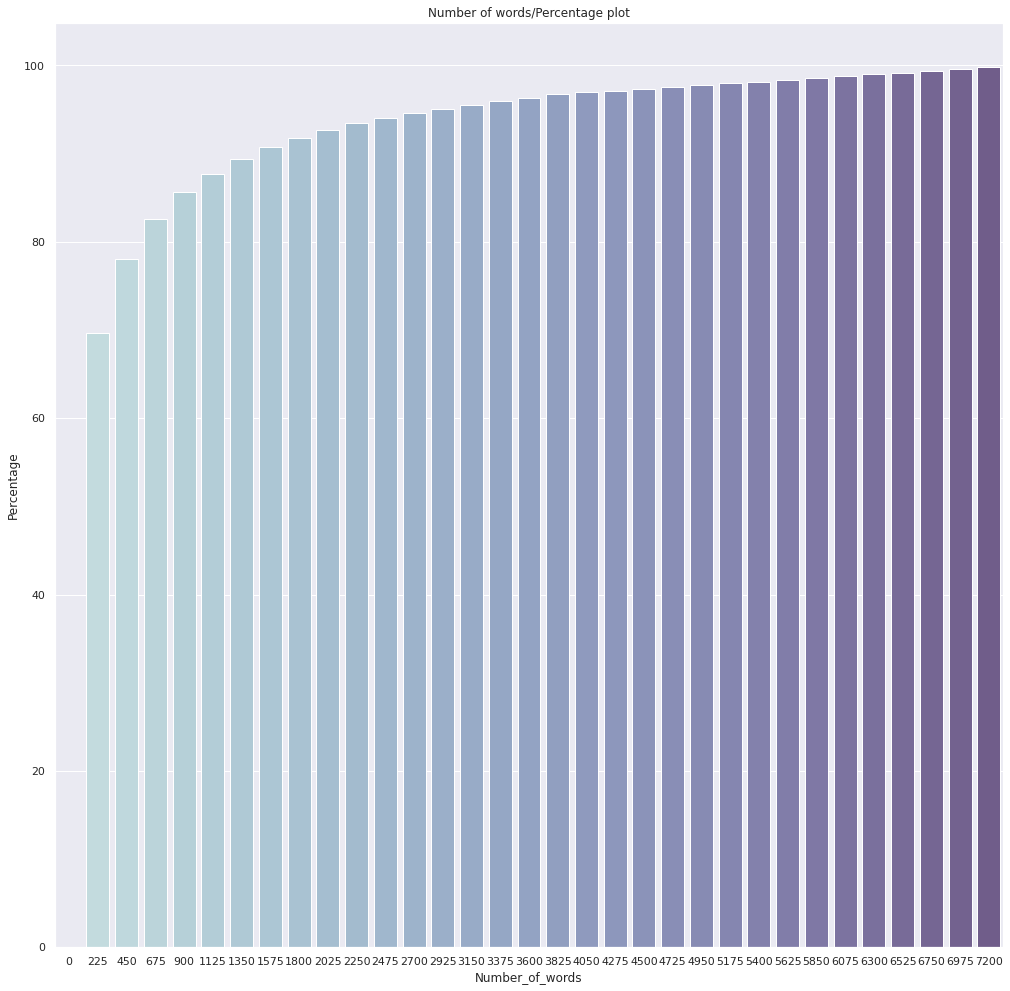

In [181]:
sns.set(rc={'figure.figsize':(17,17)})
sns.barplot(x = 'Number_of_words', y = 'Percentage', data=pd.DataFrame(counts[::9], columns = ['Number_of_words', 'Percentage']), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('Number of words/Percentage plot');

# Removing stop words

In [142]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#words_we_dont_need = ['1', 'harry', 'potter', 'ron', 'hermione', 'dumbledore', 'hagrid', 'snape', 'weasley', 'malfoy', 'dudley', 'vernon',
                      #'voldemort', 'ginny','gryffindor', 'mcgonagall', 'neville', 'george', 'lupin', 'sirius', 'fred', 'trelawney',
                      #'\t', ' ', '  ', '   ', '    ', '     ', '"', ' ','de+el', 'a+el']

words_we_dont_need = ['de+el', 'a+el']

In [0]:
words_lemma_no_stopword = words_lemma.copy()

for word in stop_words+words_we_dont_need:
  if word in words_lemma_no_stopword.keys():
    del words_lemma_no_stopword[word]

In [145]:
len(stop_words+words_we_dont_need)

315

In [0]:
words_lemma_no_stopword_df = pd.DataFrame({'words':list(words_lemma_no_stopword.keys()), 'freq': list(words_lemma_no_stopword.values())}).sort_values(by=['freq'], ascending = False)

num_lemma_no_stopword = 0
for _, row in words_lemma_no_stopword_df.iterrows():
  num_lemma_no_stopword += row['freq']

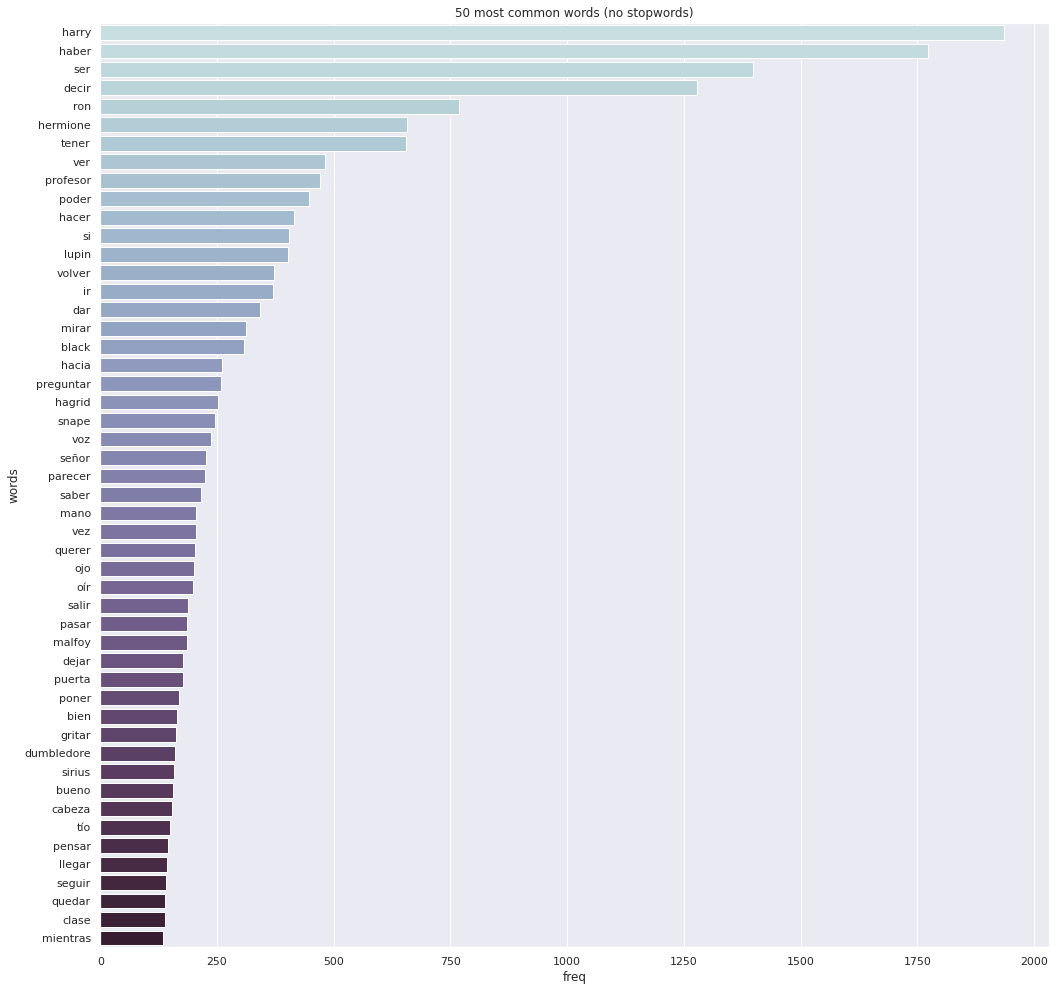

In [148]:
sns.set(rc={'figure.figsize':(17,17)});
sns.barplot(x='freq',y='words',data=words_lemma_no_stopword_df.head(50), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('50 most common words (no stopwords)');

In [149]:
counts_no_stopwords = count_percents(words_lemma_no_stopword_df, num_lemma_no_stopword)

25 most frequent words is 23.39% of the text
50 most frequent words is 30.24% of the text
100 most frequent words is 39.00% of the text
200 most frequent words is 50.03% of the text
400 most frequent words is 62.21% of the text
600 most frequent words is 69.28% of the text
800 most frequent words is 74.16% of the text
1000 most frequent words is 77.74% of the text
2000 most frequent words is 87.52% of the text
3000 most frequent words is 91.94% of the text
4000 most frequent words is 94.71% of the text
5000 most frequent words is 96.32% of the text
6000 most frequent words is 97.94% of the text
7000 most frequent words is 99.55% of the text


In [158]:
for percent in [90,93,95]:
  for line in counts_no_stopwords:
    if line[1]>percent:
      print('Knowing {} words (no stop-words) you will understand {}% of the text'.format(line[0], line[1]))
      get_level(line[0], levels)
      print()      
      break

Knowing 2500 words (no stop-words) you will understand 90.11536910044373% of the text
Number of unique words 2500 correspond to (approximately) level B1 (betwen 2000 and 4000 words).

Knowing 3350 words (no stop-words) you will understand 93.07139975796692% of the text
Number of unique words 3350 correspond to (approximately) level B1 (betwen 2000 and 4000 words).

Knowing 4200 words (no stop-words) you will understand 95.0318676885841% of the text
Number of unique words 4200 correspond to (approximately) level B2 (betwen 4000 and 8000 words).



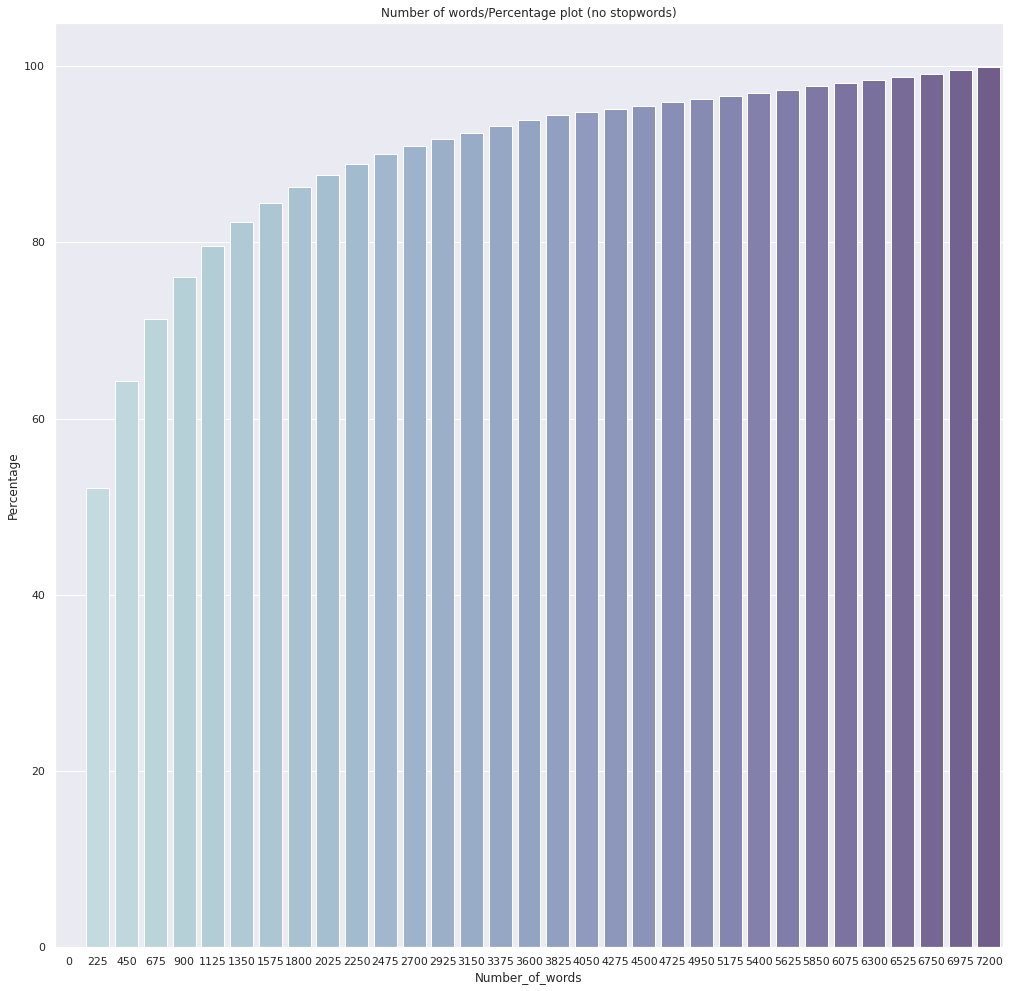

In [159]:
sns.set(rc={'figure.figsize':(17,17)})
sns.barplot(x = 'Number_of_words', y = 'Percentage', data=pd.DataFrame(counts_no_stopwords[::9], columns = ['Number_of_words', 'Percentage']), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('Number of words/Percentage plot (no stopwords)');

# Bigrams

In [0]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams

nltk.download('punkt')

In [0]:
def make_dict_bigrams(f):
  words = {}
  for i in range(len(f)):
    text = " ".join([i.lemma_ for i in nlp(re.sub('[:,\d\n?¿!¡()-.«»:;+©]|[\\x97]|[\\x92]', '', f[i]))])
    token = nltk.word_tokenize(text)
    bigrams = ngrams(token,2)
    for token in bigrams:
      if token in words.keys():
        words[token] += 1 
      else:
        words[token] = 1
  
  print('Number of unique bigrams in the text: ', len(words))

  words_df = pd.DataFrame({'bigrams':list(words.keys()), 'freq': list(words.values())}).sort_values(by=['freq'], ascending = False)
  sns.set(rc={'figure.figsize':(17,17)})
  sns.barplot(x='freq',y='bigrams',data=words_df.head(50), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('50 most common bigrams');
  return words_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: generator 'ngrams' raised StopIteration
  import sys


Number of unique bigrams in the text:  43593


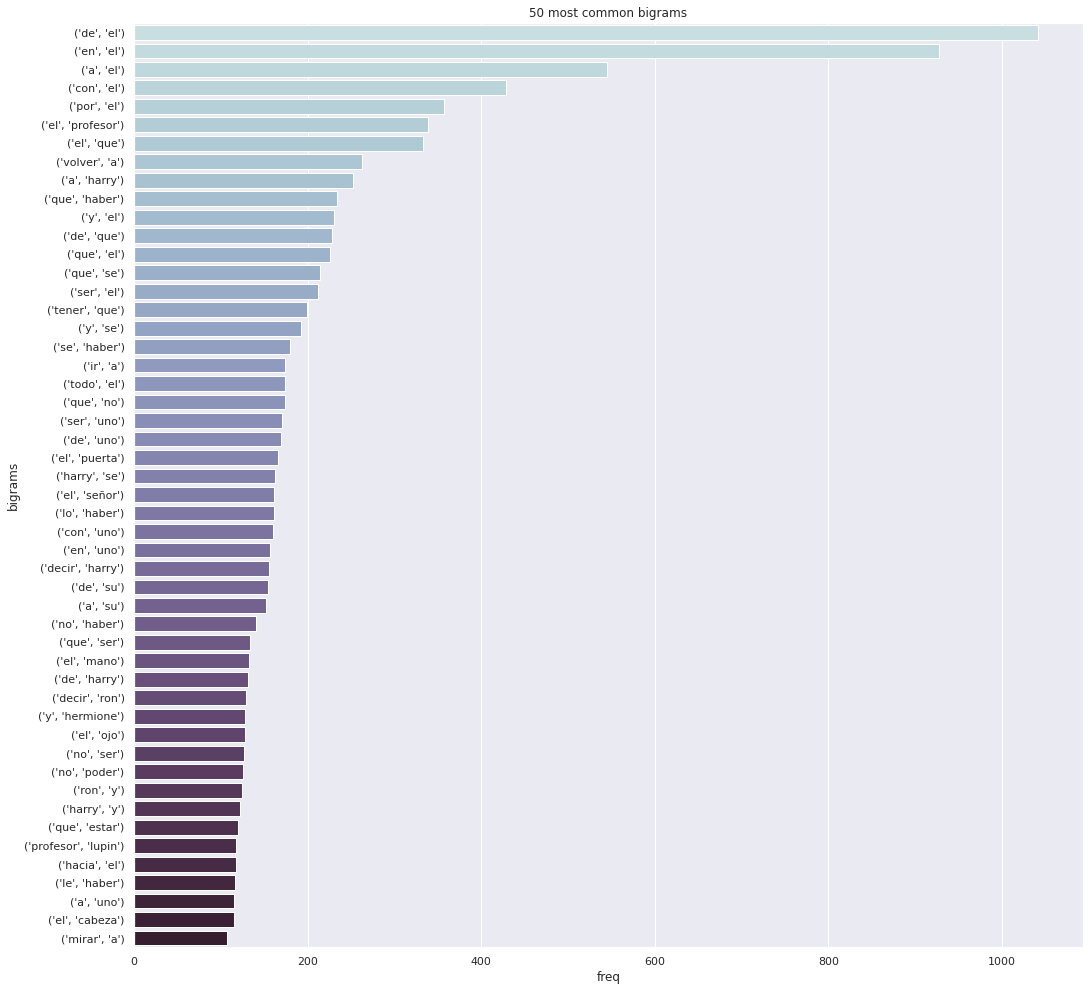

In [162]:
bigrams = make_dict_bigrams(f)

In [0]:
f_no_stopwords = [word.lemma_ for word in nlp(re.sub('[:,\d\n?¿!¡()-.«»:;+©]|[\\x97]|[\\x92]', '', line)) if word.lemma_ not in stop_words+words_we_dont_ne]

In [0]:
f_no_stopwords = []

for i in range(len(f)):
  f_no_stopwords+=[[]]
  for word in nlp(re.sub('[:,\d\n?¿!¡()-.«»:;+©]|[\\x97]|[\\x92]', '', f[i])):
    if word.lemma_ not in stop_words+words_we_dont_need:
      f_no_stopwords[i] += [word.lemma_]

In [0]:
#from nltk import everygrams
#list(everygrams(f_no_stopwords[20:24], 2, 5))

In [0]:
bigram_big_words = {}
for line in f_no_stopwords:
  for trigram in list(everygrams(line, 2, 2)):
    if ' '.join(trigram) in bigram_big_words.keys():
      bigram_big_words[' '.join(trigram)]+=1
    else:
      bigram_big_words[' '.join(trigram)]=1

In [0]:
#for i in ['tío marge', 'profesor trelawney', 'tío vernon', 'señor pomfrey', 'crabbe goyle']:
  #del bigram_big_words[i]

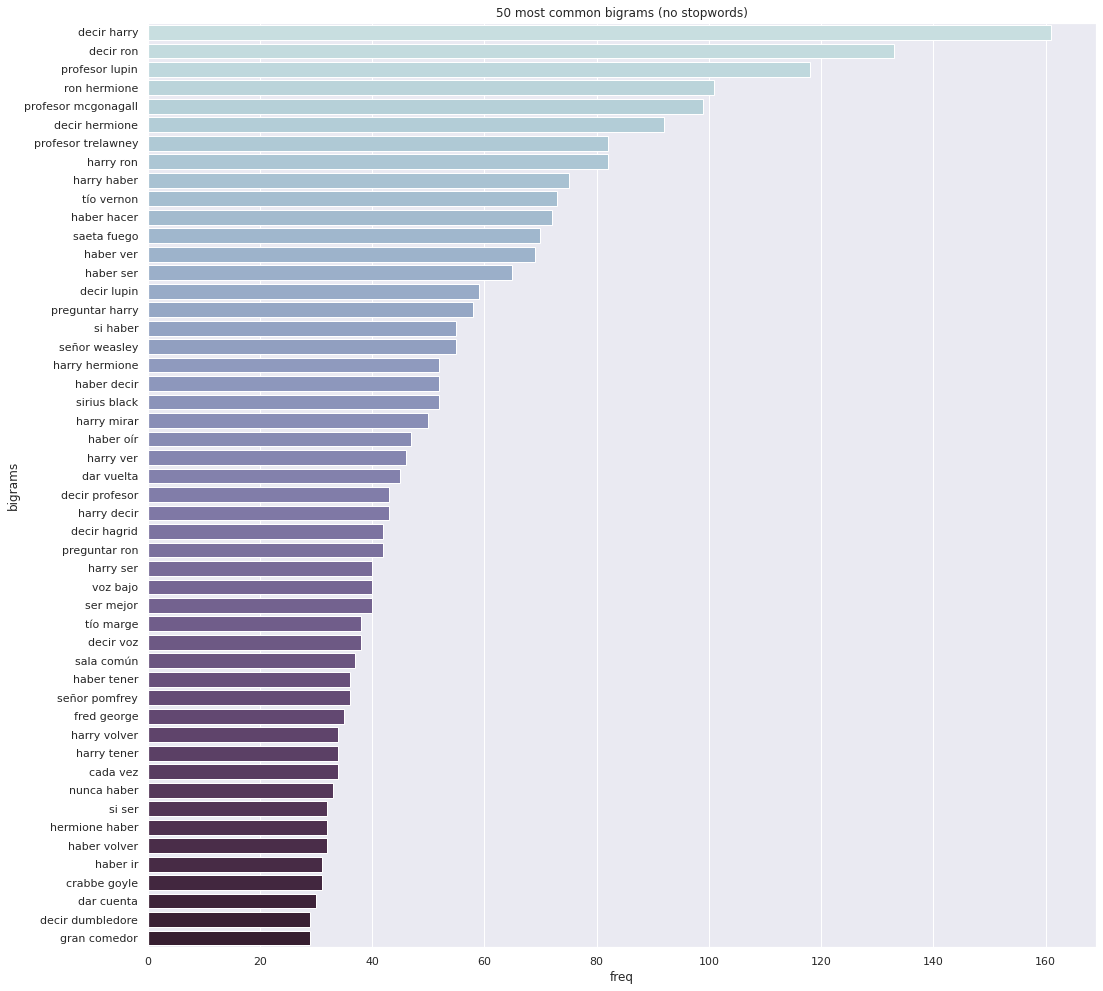

In [169]:
bigram_big_words_df = pd.DataFrame({'bigrams':list(bigram_big_words.keys()), 'freq': list(bigram_big_words.values())}).sort_values(by=['freq'], ascending = False)
sns.set(rc={'figure.figsize':(17,17)})
sns.barplot(x='freq',y='bigrams',data=bigram_big_words_df.head(50), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('50 most common bigrams (no stopwords)');

# (just for fun) Stemming

In [0]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [0]:
words_stem = {}
for line in f_no_stopwords:
  for word in line:
    if stemmer.stem(word) in words_stem.keys():
      words_stem[stemmer.stem(word)]+=1
    else:
      words_stem[stemmer.stem(word)]=1

In [0]:
words_stem_df = pd.DataFrame({'stems':list(words_stem.keys()), 'freq': list(words_stem.values())}).sort_values(by=['freq'], ascending = False)

In [0]:
len(words_stem_df)

4741

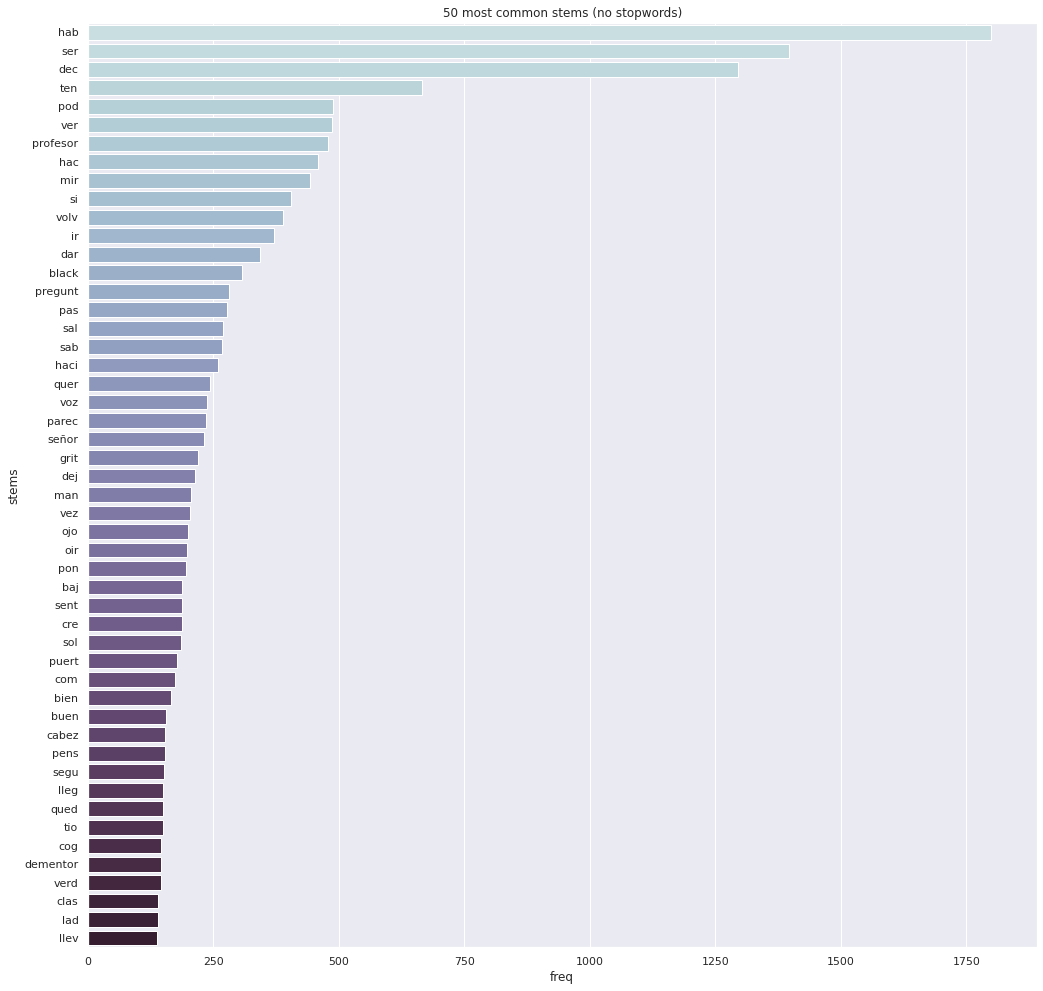

In [0]:
sns.set(rc={'figure.figsize':(17,17)})
sns.barplot(x='freq',y='stems',data=words_stem_df.head(50), palette = sns.cubehelix_palette(50, start=.75, rot=-.5)).set_title('50 most common stems  (no stopwords)');

# And?

So more or less we can understand what is going on the text. But what I was trying to do is a statistics you can use for the understanding the level of the book in the linguistic meaning. So after just taking a quick pick on the data you can evaluate time and effords you need to read it depence on your language level.

I want to list and visualize what is really needed from this pile of the information. 

I run a small survey among my friends about what they consider to be useful in this type of statistics (you can [fill it too](https://docs.google.com/forms/d/11ACe25mp2bxkx3rsHLrkehhEJ9xaxYhWGPMY7aN-UVA/edit#responses) btw)
I'm currently working on gathering more data and creating other consepts, and would be great to get a bit of feed back.

Sooo...

# Conclutions

In [0]:
def get_percent_for_level(counts_no_stopwords, num):
  for line in counts_no_stopwords:
    if line[0]==num:
      return(int(line[1]))
  return(100)

In [200]:
print('The level of the book (with 95% understanding) is {} '.format(levels_of_book_finale[0][1]), end = '\n\n')

for level in levels[:-1]:
  print('Learners with level less or equal to {} will understand {:3}% of the text'.format(level[1], get_percent_for_level(counts, level[0])))

The level of the book (with 95% understanding) is B1 

Learners with level less or equal to A1 will understand  79% of the text
Learners with level less or equal to A2 will understand  86% of the text
Learners with level less or equal to B1 will understand  92% of the text
Learners with level less or equal to B2 will understand  96% of the text
Learners with level less or equal to C1 will understand 100% of the text
Learners with level less or equal to C2 will understand 100% of the text
